<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) a deep network,
(2) method of calculating accuracy, 
(3) images that show the dense prediction produced by your network on the pos_test_000072.png image (index 172 in the validation dataset).
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 20% Proper implementation of train/test set accuracy measure
* 20% Tidy visualizations of loss of your dense predictor during training
* 20% Test image output


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

**TODO:**

* Watch tutorial

**DONE:**

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

___

Implement your network topology

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

You can simplify the implementation of this lab by padding the feature maps as they pass through each convolution. This will make the concatenation process easier, though this is technically a departure from the cropping technique outlined in the orginal U-Net paper. 

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)

**TODO:**

* Understand the U-Net architecture
* Understand concatenation of inputs from multiple prior layers
* Understand ConvTranspose
* Answer Question / Reflect on simplest network with the desired properties

**DONE:**


___
The intention of this lab is to learn how to make deep neural nets. We'll help you with the implementation of Dataset.
This code will download the dataset for you so that you are ready to use it and focus on network
implementation, losses and accuracies.

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
# print(torch.cuda.memory_allocated(0) / 1e9) # Print gpu memory in gigabytes
# # use model.cuda() NOT model = model.cuda()
# gc.collect() # force the garbage collector to clean up unused memory, call in the beginning of your loop
# # unhandled exceptions cause memory leaks
# # fix with
# try:
#   print('something')
# except:
#   __ITB__()
#
# # variables remaining in scope are another cause of memory leaks \
#   # Fix this by creating a dummy function (e.g., scope()) that you call
#
#
# for obj in gc.get_objects():
#   if torch.is_tensor(obj):
#     print(obj.size())

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [ ]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

In [ ]:
# You'll probably want a function or something to test input / output sizes of the ConvTranspose2d layer


In [ ]:
# Since you will be using the output of one network in two places(convolution and maxpooling),
# you can't use nn.Sequential.
# Instead you will write up the network like normal variable assignment as the example shown below:
# You are welcome (and encouraged) to use the built-in batch normalization and dropout layer.

# TODO: You need to change this to fit the UNet structure!!!
class CancerDetection(nn.Module):
  def __init__(self): # CancerDetection constructor
    # You always need to use super to call nn.Module's init function when creating a class that inherits nn.Module.
    super(CancerDetection, self).__init__()

    # Dropout layer
    self.dropout = nn.Dropout(p=0.2)
    
    # Always initialize your layers in the init function.
    self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
    # self.batchnorm1 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()

    self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.relu4 = nn.ReLU()

    self.maxpool5 = nn.MaxPool2d((2,2))

    self.conv6 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.relu7 = nn.ReLU()

    self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.batchnorm4 = nn.BatchNorm2d(128)
    self.relu9 = nn.ReLU()

    self.maxpool10 = nn.MaxPool2d((2,2))

    self.conv11 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.batchnorm5 = nn.BatchNorm2d(256)
    self.relu12 = nn.ReLU()

    self.conv13 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.batchnorm6 = nn.BatchNorm2d(256)
    self.relu14 = nn.ReLU()

    self.maxpool15 = nn.MaxPool2d((2,2))

    self.conv16 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.batchnorm7 = nn.BatchNorm2d(512)
    self.relu17 = nn.ReLU()

    self.conv18 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
    self.batchnorm8 = nn.BatchNorm2d(512)
    self.relu19 = nn.ReLU()

    self.maxpool20 = nn.MaxPool2d((2,2))

    self.conv21 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
    self.batchnorm9 = nn.BatchNorm2d(1024)
    self.relu22 = nn.ReLU()

    self.conv23 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
    self.batchnorm10 = nn.BatchNorm2d(1024)
    self.relu24 = nn.ReLU()

    self.convtrans25 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # doubles the dimensions

    self.conv26 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
    self.batchnorm11 = nn.BatchNorm2d(512)
    self.relu27 = nn.ReLU()

    self.conv28 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
    self.batchnorm12 = nn.BatchNorm2d(512)
    self.relu29 = nn.ReLU()

    self.convtrans30 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # doubles the dimensions

    self.conv31 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.batchnorm13 = nn.BatchNorm2d(256)
    self.relu32 = nn.ReLU()

    self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.batchnorm14 = nn.BatchNorm2d(256)
    self.relu34 = nn.ReLU()

    self.convtrans35 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # doubles the dimensions

    self.conv36 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
    self.batchnorm15 = nn.BatchNorm2d(128)
    self.relu37 = nn.ReLU()

    self.conv38 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.batchnorm16 = nn.BatchNorm2d(128)
    self.relu39 = nn.ReLU()

    self.convtrans40 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # doubles the dimensions

    self.conv41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.batchnorm17 = nn.BatchNorm2d(64)
    self.relu42 = nn.ReLU()

    self.conv43 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.batchnorm18 = nn.BatchNorm2d(64)
    self.relu44 = nn.ReLU()

    self.conv45 = nn.Conv2d(64, 2, kernel_size=3, padding=1)
 
  def forward(self, input): # nn.Module sets up a hook that calls forward when you "call" the module object: net(x) calls net.forward(x)
    conv1_out = self.conv1(input); del input
    batchnorm1_out = self.batchnorm1(conv1_out); del conv1_out
    dropout1_out = self.dropout(batchnorm1_out); del batchnorm1_out
    relu2_out = self.relu2(dropout1_out); del dropout1_out

    conv3_out = self.conv3(relu2_out); del relu2_out
    batchnorm2_out = self.batchnorm2(conv3_out); del conv3_out
    dropout2_out = self.dropout(batchnorm2_out); del batchnorm2_out
    relu4_out = self.relu4(dropout2_out); del dropout2_out

    maxpool5_out = self.maxpool5(relu4_out)

    conv6_out = self.conv6(maxpool5_out); del maxpool5_out
    batchnorm3_out = self.batchnorm3(conv6_out); del conv6_out
    dropout3_out = self.dropout(batchnorm3_out); del batchnorm3_out
    relu7_out = self.relu7(dropout3_out); del dropout3_out

    conv8_out = self.conv8(relu7_out); del relu7_out
    batchnorm4_out = self.batchnorm4(conv8_out); del conv8_out
    dropout4_out = self.dropout(batchnorm4_out); del batchnorm4_out
    relu9_out = self.relu9(dropout4_out); del dropout4_out

    maxpool10_out = self.maxpool10(relu9_out)

    conv11_out = self.conv11(maxpool10_out); del maxpool10_out
    batchnorm5_out = self.batchnorm5(conv11_out); del conv11_out
    dropout5_out = self.dropout(batchnorm5_out); del batchnorm5_out
    relu12_out = self.relu12(dropout5_out); del dropout5_out

    conv13_out = self.conv13(relu12_out); del relu12_out
    batchnorm6_out = self.batchnorm6(conv13_out); del conv13_out
    dropout6_out = self.dropout(batchnorm6_out); del batchnorm6_out
    relu14_out = self.relu14(dropout6_out); del dropout6_out

    maxpool15_out = self.maxpool15(relu14_out)

    conv16_out = self.conv16(maxpool15_out); del maxpool15_out
    batchnorm7_out = self.batchnorm7(conv16_out); del conv16_out
    dropout7_out = self.dropout(batchnorm7_out); del batchnorm7_out
    relu17_out = self.relu17(dropout7_out); del dropout7_out

    conv18_out = self.conv18(relu17_out); del relu17_out
    batchnorm8_out = self.batchnorm8(conv18_out); del conv18_out
    dropout8_out = self.dropout(batchnorm8_out); del batchnorm8_out
    relu19_out = self.relu19(dropout8_out); del dropout8_out

    maxpool20_out = self.maxpool20(relu19_out)

    conv21_out = self.conv21(maxpool20_out); del maxpool20_out
    batchnorm9_out = self.batchnorm9(conv21_out); del conv21_out
    dropout9_out = self.dropout(batchnorm9_out); del batchnorm9_out
    relu22_out = self.relu22(dropout9_out); del dropout9_out

    conv23_out = self.conv23(relu22_out); del relu22_out
    batchnorm10_out = self.batchnorm10(conv23_out); del conv23_out
    dropout10_out = self.dropout(batchnorm10_out); del batchnorm10_out
    relu24_out = self.relu24(dropout10_out); del dropout10_out

    convtrans25_out = self.convtrans25(relu24_out); del relu24_out
    convtrans25_out = torch.cat((convtrans25_out, relu19_out), dim=1); del relu19_out # ??

    conv26_out = self.conv26(convtrans25_out); del convtrans25_out
    batchnorm11_out = self.batchnorm11(conv26_out); del conv26_out
    dropout11_out = self.dropout(batchnorm11_out); del batchnorm11_out
    relu27_out = self.relu27(dropout11_out); del dropout11_out

    conv28_out = self.conv28(relu27_out); del relu27_out
    batchnorm12_out = self.batchnorm12(conv28_out); del conv28_out
    dropout12_out = self.dropout(batchnorm12_out); del batchnorm12_out
    relu29_out = self.relu29(dropout12_out); del dropout12_out

    convtrans30_out = self.convtrans30(relu29_out); del relu29_out
    convtrans30_out = torch.cat((convtrans30_out, relu14_out), dim=1); del relu14_out

    conv31_out = self.conv31(convtrans30_out); del convtrans30_out
    batchnorm13_out = self.batchnorm13(conv31_out); del conv31_out
    dropout13_out = self.dropout(batchnorm13_out); del batchnorm13_out
    relu32_out = self.relu32(dropout13_out); del dropout13_out

    conv33_out = self.conv33(relu32_out); del relu32_out
    batchnorm14_out = self.batchnorm14(conv33_out); del conv33_out
    dropout14_out = self.dropout(batchnorm14_out); del batchnorm14_out
    relu34_out = self.relu34(dropout14_out); del dropout14_out

    convtrans35_out = self.convtrans35(relu34_out); del relu34_out
    convtrans35_out = torch.cat((convtrans35_out, relu9_out), dim=1); del relu9_out

    conv36_out = self.conv36(convtrans35_out); del convtrans35_out
    batchnorm15_out = self.batchnorm15(conv36_out); del conv36_out
    dropout15_out = self.dropout(batchnorm15_out); del batchnorm15_out
    relu37_out = self.relu37(dropout15_out); del dropout15_out

    conv38_out = self.conv38(relu37_out); del relu37_out
    batchnorm16_out = self.batchnorm16(conv38_out); del conv38_out
    dropout16_out = self.dropout(batchnorm16_out); del batchnorm16_out
    relu39_out = self.relu39(dropout16_out); del dropout16_out

    convtrans40_out = self.convtrans40(relu39_out); del relu39_out
    convtrans40_out = torch.cat((convtrans40_out, relu4_out), dim=1); del relu4_out

    conv41_out = self.conv41(convtrans40_out); del convtrans40_out
    batchnorm17_out = self.batchnorm17(conv41_out); del conv41_out
    dropout17_out = self.dropout(batchnorm17_out); del batchnorm17_out
    relu42_out = self.relu42(dropout17_out); del dropout17_out

    conv43_out = self.conv43(relu42_out); del relu42_out
    batchnorm18_out = self.batchnorm18(conv43_out); del conv43_out
    dropout17_out = self.dropout(batchnorm18_out); del batchnorm18_out
    relu44_out = self.relu44(dropout17_out); del dropout17_out

    conv45_out = self.conv45(relu44_out); del relu44_out

    return conv45_out


In [ ]:
# Create your datasets, dataloaders and neural network as you have before
gc.collect()
train_dataset = CancerDataset('cancer', train=True)
val_dataset = CancerDataset('cancer', train=False)

train_loader = DataLoader(train_dataset, 
                          batch_size=3,
                          shuffle=True,
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=3,
                        shuffle=True,
                        pin_memory=True)

model = CancerDetection()
model.cuda()
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
# Tip: Pass shuffle=True to constructor for training dataloader to automatically shuffle training data each epoch. You can shuffle the validation loader, but you don't need to.

In [ ]:
# Print number of parameters in model
total = 0
for p in model.parameters():
  size = 1
  for s in p.size():
    size = size * s
  total += size
print (total)

31044610


In [ ]:
# This is what was talked about in the video for memory management

train_losses = []
validation_losses = []
train_accuracies = []
val_accuracies = []
test_images = []

def scope():
  try:
    #your code for calling dataset and dataloader
    gc.collect()
    print(torch.cuda.memory_allocated() / 1e9)

    for epoch in range(num_epochs):

      losses = []
      accuracies = []
      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(), y_truth.cuda()
        optimizer.zero_grad()

        y_hat = model(x)
        loss = objective(y_hat, y_truth.long()) # PyTorch expects the y_truth to be long
        losses.append(loss.item())
        loss.backward()

        accuracy = (torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean()
        accuracies.append(accuracy.item())

        optimizer.step()

        loop.set_description('epoch:{} loss:{:.4f}'.format(epoch, loss.item()))
        loop.update(1)

      # Record train and validation loss information for epoch
      train_losses.append(np.mean(losses))
      val_loss = np.mean([objective(model( x.cuda() ), y.cuda().long()).item()
                      for x, y in val_loader])
      validation_losses.append((len(train_losses) - 1, val_loss))

      # Record train and validation accuracy information for each epoch
      train_accuracies.append(np.mean(accuracies))
      val_accuracy = np.mean( [(torch.softmax(model( x.cuda() ), 1).argmax(1) == y.cuda()).float().mean().item()
                              for x, y in val_loader] )
      val_accuracies.append((len(train_accuracies) - 1, val_accuracy))

      if epoch % 1 == 0:
        # Make image of testing prediction every 5 epochs
        # Get the test image
        x_test, y_test = val_dataset[172]

        # Put data on GPU
        x_test, y_test = x_test.cuda(), y_test.cuda()

        # Make data in right dimensions (need batch size 1)
        x_test = x_test.unsqueeze(0)
        y_test = y_test.unsqueeze(0)

        # Turn prediction into BW image
        out_img = (torch.softmax(model(x_test), 1).argmax(1) ) \
              .squeeze(0) \
              .cpu()  \
              .detach() \
              .numpy()
        test_images.append(out_img)
      
      loop.close()
      
  except:
    __ITB__()
    
scope()

0.126207488


epoch:3 loss:0.1794:  57%|█████▋    | 255/448 [10:50<08:12,  2.55s/it]


___

### Part 2

Plot performance over time

Please generate two plots:

 One that shows loss on the training and validation set as a function of training time. 

 One that shows accuracy on the training and validation set as a function of training time. 

 Make sure your axes are labeled!

**TODO:**

* Plot training/validation loss as function of training time (not epochs)
* Plot training/validation accuracy as function of training time (not epochs)

**DONE:**



In [1]:
# Plot training and validation loss for uniform initialization
a, b = zip(*validation_losses)
f1 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.plot(train_losses, label='Training loss')
ax1.plot(a, b, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy for uniform initialization
a, b = zip(*val_accuracies)
f2 = plt.figure()
ax2 = f2.add_subplot(111)
ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(a, b, label='Validation accuracy')
ax2.axhline(y=0.85, color='black', linestyle='dashed', label='0.85')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


NameError: ignored

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

___

### Part 3

Generate at least 5 predictions on the pos_test_000072.png image and display them as images. These predictions should be made at a reasonable interval (e.g. every epoch). 

You can load this image from the file pos_test_000072.png, or you can get it from the dataset object. It is item 172 of the validation dataset.
You can print both the data instance (x) and the ground-truth label (y_hat) to see how well your network predicts on that instance.

To do this, calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent areas
the network considers cancerous.

**TODO:**

**DONE:**



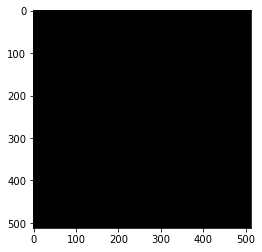

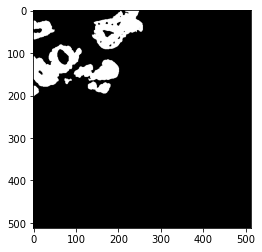

In [ ]:
# Predictions at 5 epoch intervals
import matplotlib.pyplot as plt

for image in test_images:
  f1 = plt.figure()
  ax1 = f1.add_subplot(111)
  ax1.imshow(image, cmap='Greys_r')
  plt.show()